# Multiclass multi-label classification using the Reuters dataset


This notebook shows how to implement document classification when each document can have multiple categories.

The dataset can be found [here](https://archive.ics.uci.edu/ml/machine-learning-databases/reuters21578-mld/). 
The topics to be predicted can be found in all-topics-strings.lc.txt. 
I'm adhering to the variable 'lewissplit' to define the Train/Test split. 

To convert the data from sgm to json, I'm drawing on convert_sgm_to_json.py by [mihaibogdan10](https://github.com/mihaibogdan10/json-reuters-21578).

I find the best model to predict topics is the linear support vector classifier, which gets a weighted F1 score of 72% accross 65 predicted labels. Using a combined text column (original "body" + "title" + "unknown_processed") also improves the model performance by 4% ppt. Further tuning the parameters of the SVC increases the weighted F1 score to 74%.  

The MLP model untuned also gave a weighted F1 score of 73%. I interupted the tuning as it took too long. 

In [53]:
import gzip
import collections
import matplotlib as plt
import seaborn as sns
%matplotlib inline
from os import listdir
import pandas as pd
import numpy as np
import json
import nltk
import itertools
import re
from time import time
from pandas.io.json import json_normalize
from utils import *

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score, classification_report, precision_recall_fscore_support


# import english stopwords
stop_words = set(stopwords.words('english'))

# EDA

In [2]:
path = '/Users/twenzel/repos/topics2/json-data/'
files = listdir(path)

docs = [open_file(x, path) for x in files]
docs = list(itertools.chain(*docs))
docs_df = pd.DataFrame(docs)
docs_df['topic_length'] = docs_df.topics.apply(len)

# clean column "unknown" - as it helps classifying topics when document body is empty
docs_df['unknown_processed'] = docs_df.unknown.apply(lambda x: x.split('BC-')[-1]).apply(lambda x: x.split('  ')[0])

In [3]:
# analyse the category usage
docs_df.head()

,attrs,body,companies,date,dateline,exchanges,orgs,places,title,topics,unknown,topic_length,unknown_processed
0,"{'cgisplit': 'TRAINING-SET', 'lewissplit': 'TR...",The Bank of England said it forecast a\nshorta...,[],9-MAR-1987 04:58:41.12,"LONDON, March 9 -",[],[],[uk],U.K. MONEY MARKET SHORTAGE FORECAST AT 250 MLN...,[money-fx],&#5;&#5;&#5;RM\n&#22;&#22;&#1;f0416&#31;reute\...,1,U.K.-MONEY-MARKET-SHO
1,"{'cgisplit': 'TRAINING-SET', 'lewissplit': 'TR...",The Bank of France said it invited offers\nof ...,[],9-MAR-1987 05:03:09.75,"PARIS, March 9 -",[],[],[france],BANK OF FRANCE SETS MONEY MARKET TENDER,"[money-fx, interest]",&#5;&#5;&#5;RM\n&#22;&#22;&#1;f0423&#31;reute\...,2,BANK-OF-FRANCE-SETS-M
2,"{'cgisplit': 'TRAINING-SET', 'lewissplit': 'TR...",The U.S. &lt;Amoco Petroleum Corp> has\nreport...,[],9-MAR-1987 05:03:38.51,"PEKING, March 9 -",[],[],[china],AMOCO REPORTS SOUTH CHINA SEA OIL FIND,[crude],&#5;&#5;&#5;F\n&#22;&#22;&#1;f0426&#31;reute\n...,1,AMOCO-REPORTS-SOUTH-C
3,"{'cgisplit': 'TRAINING-SET', 'lewissplit': 'TR...",Technology transfer problems have delayed\nthe...,[],9-MAR-1987 05:12:17.12,"SEOUL, March 9 -",[],[],[south-korea],SOUTH KOREA DELAYS CONTRACT FOR NUCLEAR PLANTS,[],&#5;&#5;&#5;F\n&#22;&#22;&#1;f0437&#31;reute\n...,0,SOUTH-KOREA-DELAYS-CO
4,"{'cgisplit': 'TRAINING-SET', 'lewissplit': 'TR...",Keiaisha Co Ltd of Tokyo is issuing 12\nmln Sw...,[],9-MAR-1987 05:19:27.56,"ZURICH, March 9 -",[],[],[switzerland],KEIAISHA ISSUING 12 MLN SWISS FRANC NOTES,[],&#5;&#5;&#5;RM\n&#22;&#22;&#1;f0442&#31;reute\...,0,KEIAISHA-ISSUING-12-M


In [4]:
# Look at unique topics
topic_path = '/Users/twenzel/repos/topics2/other-data/all-topics-strings.lc.txt'
topics = pd.read_csv(topic_path).acq.tolist()
print(topics)

['alum', 'austdlr', 'austral', 'barley', 'bfr', 'bop', 'can', 'carcass', 'castor-meal', 'castor-oil', 'castorseed', 'citruspulp', 'cocoa', 'coconut', 'coconut-oil', 'coffee', 'copper', 'copra-cake', 'corn', 'corn-oil', 'cornglutenfeed', 'cotton ', 'cotton-meal', 'cotton-oil', 'cottonseed', 'cpi', 'cpu', 'crude', 'cruzado', 'dfl', 'dkr', 'dlr', 'dmk', 'drachma', 'earn', 'escudo', 'f-cattle', 'ffr', 'fishmeal', 'flaxseed', 'fuel', 'gas', 'gnp', 'gold', 'grain', 'groundnut', 'groundnut-meal', 'groundnut-oil', 'heat', 'hk', 'hog', 'housing', 'income', 'instal-debt', 'interest', 'inventories', 'ipi', 'iron-steel', 'jet', 'jobs', 'l-cattle', 'lead', 'lei', 'lin-meal', 'lin-oil', 'linseed', 'lit', 'livestock', 'lumber', 'lupin', 'meal-feed', 'mexpeso', 'money-fx', 'money-supply', 'naphtha     ', 'nat-gas', 'nickel', 'nkr', 'nzdlr', 'oat', 'oilseed', 'orange', 'palladium', 'palm-meal', 'palm-oil', 'palmkernel', 'peseta', 'pet-chem', 'platinum', 'plywood', 'pork-belly', 'potato', 'propane', 'ra

In [5]:
# Count frequency of topics used
cats_combo = list(itertools.chain(*docs_df.topics.tolist()))
counter=collections.Counter(cats_combo)
print(counter.most_common)

<bound method Counter.most_common of Counter({'earn': 3987, 'acq': 2448, 'money-fx': 801, 'crude': 634, 'grain': 628, 'trade': 552, 'interest': 513, 'wheat': 306, 'ship': 305, 'corn': 254, 'dlr': 217, 'oilseed': 192, 'money-supply': 190, 'sugar': 184, 'gnp': 163, 'coffee': 145, 'veg-oil': 137, 'gold': 135, 'nat-gas': 130, 'soybean': 120, 'bop': 116, 'livestock': 114, 'cpi': 112, 'reserves': 84, 'copper': 78, 'jobs': 76, 'cocoa': 76, 'carcass': 75, 'yen': 69, 'rice': 67, 'iron-steel': 67, 'gas': 65, 'ipi': 65, 'alum': 63, 'cotton': 63, 'barley': 54, 'meal-feed': 51, 'rubber': 51, 'zinc': 44, 'palm-oil': 43, 'pet-chem': 41, 'silver': 37, 'rapeseed': 35, 'lead': 35, 'sorghum': 35, 'tin': 33, 'strategic-metal': 32, 'wpi': 32, 'orange': 29, 'fuel': 28, 'hog': 27, 'soy-meal': 27, 'retail': 27, 'heat': 25, 'soy-oil': 25, 'housing': 21, 'stg': 21, 'income': 18, 'lei': 17, 'lumber': 17, 'sunseed': 17, 'dmk': 15, 'tea': 15, 'oat': 14, 'platinum': 12, 'nickel': 11, 'groundnut': 10, 'l-cattle': 9,

We see a lot of topics appear only ones. We will need to subset on the topics that appear at least a few times in the training and test set. More observations for these topics has to be collected to make meaningful predictions for these cases.

# Labels 

What are the most common labels?

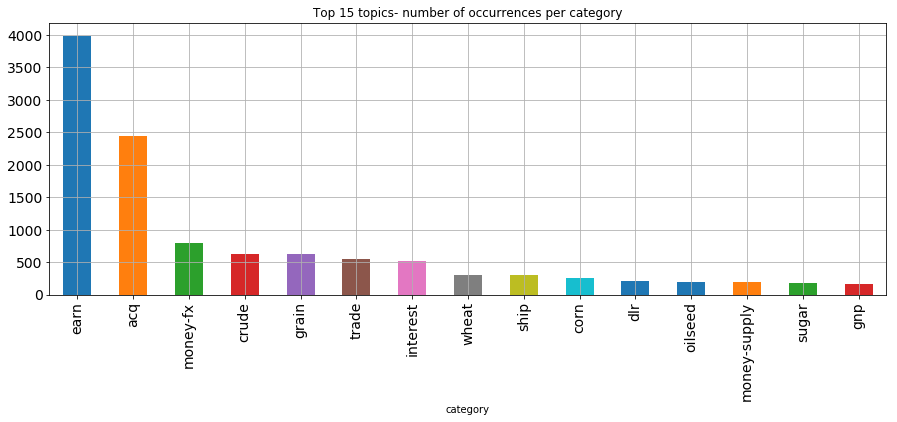

In [6]:
# plot topic frequencies
cat_df = pd.DataFrame.from_dict(counter, orient='index').reset_index()
cat_df.columns=['category', 'number_of_occurrences']
cat_df.sort_values(by = ['number_of_occurrences'], ascending=False, inplace=True)

cat_df.head(15).plot(x='category', 
                     y='number_of_occurrences', 
                     kind='bar', 
                     legend=False, 
                     grid=True, 
                     figsize=(15, 5), 
                     fontsize = 14,
                     title="Top 15 topics- number of occurrences per category")

# Multilabel 

How many articles have several labels?

47% of documents are not labelled.


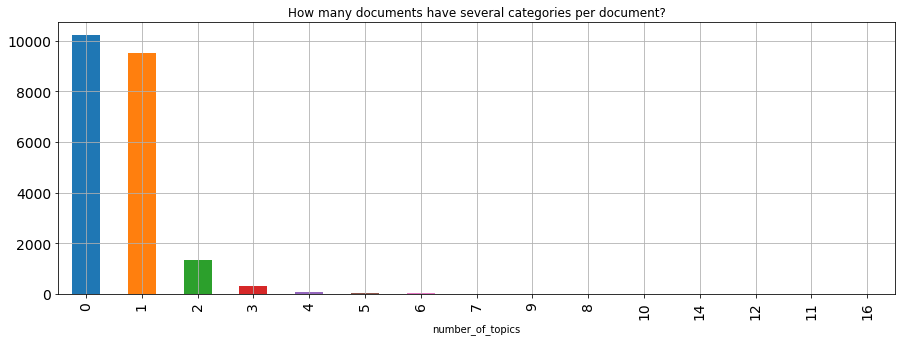

In [7]:
label_count_df = docs_df.topic_length.value_counts().reset_index()
label_count_df.columns = ['number_of_topics','number_of_occurrences']

label_count_df.plot(x='number_of_topics', 
                     y='number_of_occurrences', 
                     kind='bar', 
                     legend=False, 
                     grid=True, 
                     figsize=(15, 5), 
                     fontsize = 14,
                     title="How many documents have several categories per document?")
print('{:.0%} of documents are not labelled.'.format(docs_df[docs_df.topic_length==0].shape[0]/docs_df.shape[0]))

In [8]:
# Create dummies for each label - binary matrix over multiple labels
cat_df = pd.get_dummies(docs_df.topics.apply(pd.Series).stack()).sum(level=0)
# replace all 2s with 1
cat_df.replace(to_replace=2, value=1, inplace=True)
# combine 
docs_df = pd.concat([docs_df, cat_df], axis=1, join_axes=[docs_df.index]).fillna(0)

# Create attributes df
attr = pd.DataFrame()
for n in range(len(docs)):
    attr = attr.append(json_normalize(docs[n]['attrs']))
attr = attr.reset_index().drop('index',axis=1)
attr.drop('topics',axis=1, inplace=True)

# combine dfs
docs_df = pd.concat([docs_df, attr], axis=1, join_axes=[docs_df.index]).fillna(0)

# Imbalances

In [13]:
# Now that the lewissplit column is included in dataframe, we can check the multilabel occurrences acrocc train & test
docs_df[docs_df['lewissplit']!='NOT-USED'].groupby('lewissplit')['topic_length'].value_counts()

lewissplit  topic_length
TEST        0               3166
            1               2583
            2                310
            3                 64
            4                 32
            5                 14
            6                  6
            7                  4
            8                  2
            9                  2
            14                 2
            10                 1
            11                 1
            12                 1
TRAIN       0               6888
            1               6555
            2                892
            3                191
            4                 62
            5                 39
            6                 21
            7                  7
            8                  4
            9                  4
            10                 3
            12                 1
            16                 1
Name: topic_length, dtype: int64

In [14]:
# Imbalances: Check whether the same labels occur equally often in train and test
topiclist= cat_df.columns.tolist()
topiclist.extend(['lewissplit'])
data_to_plot = docs_df[topiclist][docs_df['lewissplit']!='NOT-USED']
data_to_plot = data_to_plot.groupby('lewissplit').sum().transpose()

# Creating a list of biggest categories to plot how imbalanced their frequencies are btw. test and train
test_cats = data_to_plot[data_to_plot.TEST>data_to_plot.TEST.mean()+(0.1*data_to_plot.TEST.std())].index.tolist()
train_cats = data_to_plot[data_to_plot.TRAIN>data_to_plot.TRAIN.mean()+(0.1*data_to_plot.TEST.std())].index.tolist()
all_cats = list(set(test_cats).intersection(train_cats))

# subset on selected categories and melt df for plotting 
data_to_plot = data_to_plot[data_to_plot.index.isin(all_cats)]
data_to_plot['topics'] = data_to_plot.index
data_to_plot = pd.melt(data_to_plot, id_vars="topics", var_name="split", value_name="frequency")

Text(0.5,1,'Imbalanced occurrences of topics btw. train and test set')

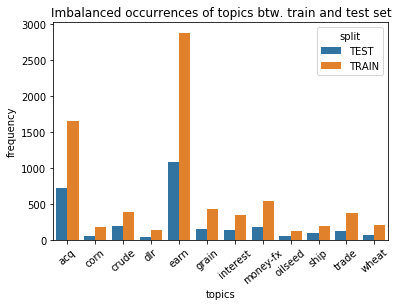

In [15]:
p = sns.barplot(x="topics", 
            y="frequency", 
            hue="split", 
            data=data_to_plot)
p.set_xticklabels(rotation=40,labels = p.get_xticklabels())
p.set_title("Imbalanced occurrences of topics btw. train and test set")

# Length of documents

Number of missing comments in document body:{} 0
Most documents contain less than 508 characters. The longest document contains 13400 characters.


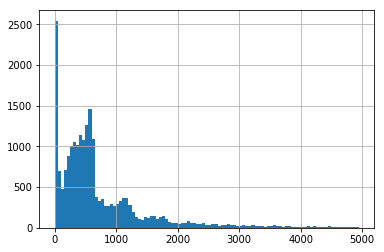

In [16]:
lens = docs_df.body.str.len()

print('Number of missing comments in document body:{}',format(docs_df['body'].isnull().sum()))

lens.hist(bins = np.arange(0,5000,50))
print('Most documents contain less than {} characters. The longest document contains {} characters.'
      .format(int(docs_df.body.str.len().median()),
              int(docs_df.body.str.len().max()))
     )

In [17]:
'We also see a large number of documents w/o any text: {}'.format(docs_df[docs_df.body.str.len()==0].shape[0])

'We also see a large number of documents w/o any text: 2535'

In [18]:
print('They are still allocated to training & test group as the below shows:')
docs_df[docs_df.body.str.len()==0].lewissplit.value_counts()

They are still allocated to training & test group as the below shows:


TRAIN       1803
TEST         730
NOT-USED       2
Name: lewissplit, dtype: int64

In [19]:
print('If the body is missing, the title and unknown field can be used to predict labels.')
docs_df[docs_df.body.str.len()==0][['title','unknown_processed','topics']].head()

If the body is missing, the title and unknown field can be used to predict labels.


,title,unknown_processed,topics
5,NATIONAL WESTMINSTER BANK SAYS IT CUTTING BASE...,NATIONAL-WESTMINSTER,[interest]
34,Chrysler to take over Renault stake in America...,Chrysler-to-take-over,[acq]
36,SOUTHERN CO TO TAKE 226 MLN DLR CHARGE ON PROJ...,******southern-co-to,[earn]
40,GENCORP TO SELL LOS ANGELES TELEVISION STATION...,******GENCORP-TO-SELL,[acq]
48,FRENCH JAN M-3 MONEY SUPPLY ROSE PROV ADJUSTED...,FRENCH-JAN-M-3-MONEY,[money-supply]


In [20]:
# 1 document is w/o body, title and unknown field. We will exclude it from Training.
docs_df[(docs_df.body.str.len()==0) & (docs_df.title.str.len()==0) & (docs_df.unknown_processed.str.len()==0)][['newid','unknown_processed','title','body','topics','lewissplit' ]]

,newid,unknown_processed,title,body,topics,lewissplit
9792,12793,,,,[],TRAIN


In [21]:
docs_df['body'] = docs_df.body.apply(lambda x: clean_text(x))
docs_df['unknown_processed'] = docs_df.unknown_processed.apply(lambda x: clean_text(x))
docs_df['unknown_processed'].head()

# Create additional text variable containing body, title & unknown_processed combined. This should help classifying documents where one of the fields, e.g. body is missing.
docs_df['txt_combined'] = docs_df['body'] + ' ' + docs_df['title'] + ' ' + docs_df['unknown_processed']
docs_df['txt_combined2'] = docs_df.apply(lambda x: process_text(x), axis=1)

In [22]:
docs_df[['newid','unknown_processed','title','body','topics','txt_combined','lewissplit' ]].tail()

,newid,unknown_processed,title,body,topics,txt_combined,lewissplit
21573,16996,state of n j in m,STATE OF N.J. IN 43 MLN DLR PROGRAM STOCK SALE,the state of new jersey said that it sold st...,[],the state of new jersey said that it sold st...,NOT-USED
21574,16997,du pont lt dd conoco,DU PONT'S &lt;DD> CONOCO FINDS OIL OFFSHORE CONGO,du pont co conoco inc said the viodo marine nu...,[crude],du pont co conoco inc said the viodo marine nu...,NOT-USED
21575,16998,falconbridge lt falcf o,FALCONBRIDGE &lt;FALCF.O> SEES IMPROVED RESULTS,falconbridge ltd said it expected results for ...,"[nickel, acq]",falconbridge ltd said it expected results for ...,NOT-USED
21576,16999,symbol technologies lt,SYMBOL TECHNOLOGIES &lt;SMBL.O> FILES SHARE OFFER,symbol technologies inc said it filed with the...,[],symbol technologies inc said it filed with the...,NOT-USED
21577,17000,transcanada lt trp den,TRANSCANADA &lt;TRP> DENIES REPORTS OF NEW BID,transcanada pipelines ltd denied reports that ...,[acq],transcanada pipelines ltd denied reports that ...,NOT-USED


# Train test split

In [23]:
X_train = docs_df[(docs_df.lewissplit=='TRAIN') & (docs_df.newid !=12793)]
X_test = docs_df[(docs_df.lewissplit=='TEST')].drop('topics', axis=1)

# categories to predict - subset on categories that appear more than twice in the training & test set
cat_obs_count_train = X_train[cat_df.columns.tolist()].sum()>5
categories_with_enough_obs_train = cat_obs_count_train[cat_obs_count_train.values].index.tolist()

cat_obs_count_test = X_test[cat_df.columns.tolist()].sum()>5
categories_with_enough_obs_test = cat_obs_count_test[cat_obs_count_test.values].index.tolist()
categories_with_enough_obs = list(set(categories_with_enough_obs_train).intersection(set(categories_with_enough_obs_test))) 

Y_train = X_train[categories_with_enough_obs].as_matrix()
print('Some topics only occur once or twice. To ensures that we can calculate model performance metrics, we will use only {}/120 topics for prediction.  (In practice, a much higher threshold should be set, e.g. 20 times to train a classifier for a label.)'.format(len(categories_with_enough_obs)))

Some topics only occur once or twice. To ensures that we can calculate model performance metrics, we will use only 56/120 topics for prediction.  (In practice, a much higher threshold should be set, e.g. 20 times to train a classifier for a label.)


# Train classifier

Next we train a classifier that fits our problem. We have multiple classes (120 topics) amd each document can belong to multiple classes (up to 16) at the same time. A multi-class multi-label classifier is appropriate in such situations and can be implemented in scikit-learn. 

### OneVsRest multi-label strategy
The OneVsRest strategy can be used for multi-label learning, where a classifier is used to predict multiple labels for each input. This classifier accepts a binary mask over multiple labels. We constructed this in cat_df. The result for each prediction will be an array of 0s and 1s marking which class labels apply to each row input sample.

### Linear classifiers
The next step implements several linear classifiers: Multi-class version of Naive Bayes (MultinomialNB), stochastic gradient descent (SGDClassifier), Support Vector (LinearSVC), Stochastic gradient descent (SGDClassifier).

### Non-linear classifiers
To allow for more complex relationship modeling, I compare the linear classifiers to a multi-layer perceptron (MLP) classifier. 

### Why are these models suitable? 

**Naive Bayes** and **SVM** are often considered baseline models in text classification. 

**Naive Bayes** classifier is suitable for classification with discrete features (e.g., word counts for text classification). 
- It assumes that the probability of occurrence of any word given the class label, is independent of the probability of occurrence of any other word, given its class label.
- It also assumes the probability of occurrence of a word in a document, is independent of the location of that word within the document.

Text data roughly follows these assumptions, making naive Bayes a good model for text classification problems.  
I used the multinomial version here because

The **linear support vector machine** extracts the best possible hyper-plane / line that segregates the two classes. It has been found to be one of the best models for text classification. The linear kernel SVM is often recommended for text classification because text is often linearly separable, text has a lot of features. The linear Kernel is most suitable for these cases and is also than other Kernels. 

It has been [found](https://nlp.stanford.edu/pubs/sidaw12_simple_sentiment.pdf) that NB works better for shorter texts, whereas SVM works better for longer texts. Since the Reuters dataset also has longer documents, this may be one of the reasons why SVM performs best here. 


**Logistic Regression** classifier measures the relationship between the categorical dependent variable and independent variables by estimating probabilities using a sigmoid function. It is a great baseline model 

**SGD** is a simple and efficient numerical optimisation method that is used in many machine learning applications. Stochastic gradient descent classifier is a linear classifier (SVM, logistic regression) that uses SGD for training (minimising the loss function). 
Linear classifiers (SVM, logistic regression, a.o.) with SGD training, whereby the loss function determins the classifier. ‘Log’ loss gives logistic regression, ‘hinge’ (default) gives a linear SVM.

A **multi-layer perceptron** is a feedforward neural network that has three or more layers. It utilizes a nonlinear activation function (mainly hyperbolic tangent or logistic function) that lets it classify data that are not linearly separable. Every node in a layer connects to each node in the following layer making the network fully connected.
MPL can get better results than NB or SVM because of the non-linearity introduced which may be present in some text classification problems. Hence it's worth trying here since other models do not allow for non-linearity.


### Pipeline
In order to make the vectorizer => transformer => classifier easier to work with, scikit-learn provides a Pipeline class that behaves like a compound classifier. 

The text is passed into a processing step (TfidfVectorizer), which converts a collection of raw documents to a matrix of TF-IDF features. This step counts the term frequencies in the text and scales down terms that occur very frequently in the corpus of documents. Hence, less informative terms have lower values. 

### Model performance metrics
I chose F1 score as evaluation metric to optimise, since it is more robust to imbalanced classes than, e.g. the accuracy score. Using the accuracy score, it is easy to get a score around 99% by simply predicting the majority class, which is zero. 

There are other options: 
- Label ranking average precision: The correct labels should be ranked higher and this metric yields better scores if the model is able to give better rank to the labels associated with each sample. 
- Precision@k

![](eval_metrics.png)
Reference: http://kt.ijs.si/DragiKocev/wikipage/lib/exe/fetch.php?media=2012pr_ml_comparison.pdf


# Tuning
I use randomized search, which search the parameter space more efficiently than exhaustive GridSearch.

### Possible extensions
- Ensemble: train several classifiers on other non-text variables and combine predictions of text and non-text models. For example, performance can be improved by training 1 classifier using text, another using the non-text information in the documents and then combining the 2 classifiers in an ensemble. 
- Keras implementations to scale on bigger dataset, e.g. [Reuters dataset](https://github.com/philipperemy/Reuters-full-data-set)
- Try [nlp.fast.ai](http://nlp.fast.ai/classification/2018/05/15/introducting-ulmfit.html) and [Facebook fastText](https://github.com/facebookresearch/fastText) 
- Explore bigger parameter space using further efficiency improvements (early stopping in random search)
- Feature engineering: e.g. word embedding layers for deep learning with Keras, Word2Vec, GloVe
- Rerun models on full Reuters dataset 

# Linear SVC

In [24]:
# silence some warnings (version incompatibilities btw. h5py and numpy)
import warnings
warnings.simplefilter('ignore')

In [33]:
SVC_clf = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=6)),
            ])
svc_scores = {}
for category in categories_with_enough_obs:
    print('... Processing {}'.format(category))
    # train the model using train_body & y_class
    SVC_clf.fit(X_train.body, X_train[category])
    # compute the testing F1 score
    prediction = SVC_clf.predict(X_test.body)
    f1_value = f1_score(X_test[category], prediction)
    svc_scores[category] = f1_value
    print('Test F1 score is {}'.format(f1_value))

... Processing livestock
Test F1 score is 0.3076923076923077
... Processing hog
Test F1 score is 0.30769230769230765
... Processing palm-oil
Test F1 score is 0.5714285714285715
... Processing sorghum
Test F1 score is 0.30769230769230765
... Processing money-fx
Test F1 score is 0.5244755244755245
... Processing alum
Test F1 score is 0.3571428571428571
... Processing meal-feed
Test F1 score is 0.2727272727272727
... Processing dlr
Test F1 score is 0.4067796610169491
... Processing cocoa
Test F1 score is 0.6666666666666666
... Processing gold
Test F1 score is 0.41860465116279066
... Processing acq
Test F1 score is 0.754047802621434
... Processing gas
Test F1 score is 0.5217391304347826
... Processing oat
Test F1 score is 0.0
... Processing iron-steel
Test F1 score is 0.4
... Processing carcass
Test F1 score is 0.3478260869565218
... Processing orange
Test F1 score is 0.625
... Processing reserves
Test F1 score is 0.6153846153846153
... Processing gnp
Test F1 score is 0.689655172413793
...

In [34]:
# Alternative way to run it w/o for loop
SVC_clf = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=6)),
            ])
SVC_clf.fit(X_train.body, Y_train)
prediction = SVC_clf.predict(X_test.body)
svc_f1 = f1_score(X_test[categories_with_enough_obs].as_matrix(), prediction, average='weighted')
print('F1 score (weighted to account for class imbalances) support vector classifier: {:.2f}'.format(svc_f1))

F1 score (weighted to account for class imbalances) support vector classifier: 0.68


In [208]:
# precision, recall,fbeta_score,support = precision_recall_fscore_support(X_test[categories_with_enough_obs].as_matrix(), prediction, average=None)
# precision_recall_fscore_support(X_test[categories_with_enough_obs].as_matrix(), prediction, average='weighted')
# from sklearn.metrics import fbeta_score
# fbeta_score(X_test[categories_with_enough_obs].as_matrix(), prediction, beta=0.1, average='weighted')

In [35]:
print('Check the detailed classification performance by label:')
print(classification_report(X_test[categories_with_enough_obs].as_matrix(), 
                            prediction,
                            target_names=X_test[categories_with_enough_obs].columns.tolist())
     )

Check the detailed classification performance by label:
                 precision    recall  f1-score   support

      livestock       0.40      0.25      0.31        24
            hog       0.29      0.33      0.31         6
       palm-oil       1.00      0.40      0.57        10
        sorghum       0.67      0.20      0.31        10
       money-fx       0.71      0.42      0.52       180
           alum       1.00      0.22      0.36        23
      meal-feed       1.00      0.16      0.27        19
            dlr       0.80      0.27      0.41        44
          cocoa       1.00      0.50      0.67        18
           gold       0.69      0.30      0.42        30
            acq       0.85      0.68      0.75       719
            gas       1.00      0.35      0.52        17
            oat       0.00      0.00      0.00         6
     iron-steel       0.67      0.29      0.40        14
        carcass       0.80      0.22      0.35        18
         orange       1.00     

In [36]:
# Compare model with 'body' vs. model with 'txt_combined'
SVC_clf2 = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=6)),
            ])
SVC_clf2.fit(X_train.txt_combined, Y_train)
prediction = SVC_clf2.predict(X_test.txt_combined)
svc2_f1 = f1_score(X_test[categories_with_enough_obs].as_matrix(), prediction, average='weighted')
print('F1 score (weighted to account for class imbalances) for support vector classifier: {:.2f}'.format(svc2_f1))

F1 score (weighted to account for class imbalances) for support vector classifier: 0.72


In [37]:
# Comparing the performance btw.'body' and 'txt_combined'
# diff = {x: svc_scores2[x] - svc_scores[x] for x in svc_scores2 if x in svc_scores}
print('Using the combined text variable "txt_combined" instead of "body" improves the F1 score by {:.0%} points on average.'.format(svc2_f1-svc_f1))

Using the combined text variable "txt_combined" instead of "body" improves the F1 score by 4% points on average.


A point to note is that the performance for documents with "body" actually seems to worsen. A better feature may be to use "txt_combined" whenever "body" is empty. Let's test this with 'txt_combined2'.

In [38]:
# Compare model with 'body' vs. model with 'txt_combined'
SVC_clf3 = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=6)),
            ])
SVC_clf3.fit(X_train.txt_combined2, Y_train)
prediction = SVC_clf3.predict(X_test.txt_combined2)
svc3_f1 = f1_score(X_test[categories_with_enough_obs].as_matrix(), prediction, average='weighted')
print('F1 score (weighted to account for class imbalances) for SVC: {:.2f}'.format(svc3_f1))
print("We don't get a better performance than when concatenating all text fields as input variable (txt_combined). Hence we continue benchmarking models using 'txt_combined'.")

F1 score (weighted to account for class imbalances) for SVC: 0.71
We don't get a better performance than when concatenating all text fields as input variable (txt_combined). Hence we continue benchmarking models using 'txt_combined'.


In [114]:
# Print largest coefficients
vec, clf = SVC_clf.named_steps['tfidf'], SVC_clf.named_steps['clf']
coefs = pd.Series(clf.coef_[0], index=vec.get_feature_names())
print("\n20 most discriminating words:")
print(coefs[coefs.abs().sort_values(ascending=False).index][:20])


20 most discriminating words:
shipping        2.631469
ships           2.341930
vessels         2.072995
port            1.945230
vessel          1.706659
mt              1.581577
seamen          1.579861
cargo           1.427407
ship            1.311303
canal           1.301302
sea             1.231398
freight         1.214308
tankers         1.202379
dwt             1.171242
transport       1.162541
harbour         1.116598
river           1.090166
tanker          1.048441
warships        1.048380
shipbuilding    0.948403
dtype: float64


# Stochastic gradient descent 

In [39]:
SGD_clf = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(SGDClassifier(), n_jobs=6)),
            ])
SGD_clf.fit(X_train.txt_combined, Y_train)
prediction = SGD_clf.predict(X_test.txt_combined)
sgd_f1 = f1_score(X_test[categories_with_enough_obs].as_matrix(), prediction, average='weighted')
print('Weighted F1 score stochastic gradient descent classifier: {:.2f}'.format(sgd_f1))

Weighted F1 score stochastic gradient descent classifier: 0.70


In [40]:
# Comparing SVC vs. SGD model performance 
print('Using a default SVC instead of SGD classifier improves the F1 score by {:.0%} points average.'.format(svc2_f1-sgd_f1))

Using a default SVC instead of SGD classifier improves the F1 score by 2% points average.


Hence the best default model remains the Support vector classifier. 

# MultinomialNB


In [41]:
NB_clf = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MultinomialNB( 
                        fit_prior=False, class_prior=None), n_jobs=6)),
            ])
NB_clf.fit(X_train.txt_combined, Y_train)
prediction = NB_clf.predict(X_test.txt_combined)
nb_f1 = f1_score(X_test[categories_with_enough_obs].as_matrix(), prediction, average='weighted')
print('Weighted F1 score Multinomial Bayes classifer: {:.2f}'.format(nb_f1))

Weighted F1 score Multinomial Bayes classifer: 0.38


In [43]:
print('Performance change: SVC vs. naive bayes classifer: {:.0%} points.'.format(svc2_f1-nb_f1))

Performance change: SVC vs. naive bayes classifer: 33% points.


# Logistic Regression

In [46]:
LR_clf = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=6)),
            ])
LR_clf.fit(X_train.txt_combined, Y_train)
prediction = LR_clf.predict(X_test.txt_combined)
lr_f1 = f1_score(X_test[categories_with_enough_obs].as_matrix(), prediction, average='weighted')
print('Weighted F1 score Logistic regression classifer: {:.2f}'.format(lr_f1))

Weighted F1 score Logistic regression classifer: 0.56


In [47]:
print('Performance change: SVC vs. Logistic classifer: {:.0%} points.'.format(svc2_f1-lr_f1))

Performance change: SVC vs. Logistic classifer: 16% points.


# Multi-layer percetron

In [50]:
MLP_clf = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(MLPClassifier(solver='lbfgs'))),
                 ])
MLP_clf.fit(X_train.txt_combined, Y_train)
prediction = MLP_clf.predict(X_test.txt_combined)
mlp_f1 = f1_score(X_test[categories_with_enough_obs].as_matrix(), prediction, average='weighted')
print('Weighted F1 score MLP classifer: {:.2f}'.format(mlp_f1))

Weighted F1 score MLP classifer: 0.73


In [51]:
print('Performance change: SVC vs. MLP classifer: {:.0%} points.'.format(svc2_f1-mlp_f1))

Performance change: SVC vs. MLP classifer: -1% points.


# Random Forest

In [54]:
RF_clf = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words)),
                ('clf', OneVsRestClassifier(RandomForestClassifier(), n_jobs=6)),
            ])
RF_clf.fit(X_train.txt_combined, Y_train)
prediction = RF_clf.predict(X_test.txt_combined)
rf_f1 = f1_score(X_test[categories_with_enough_obs].as_matrix(), prediction, average='weighted')
print('Weighted F1 score Random forest classifer: {:.2f}'.format(rf_f1))

Weighted F1 score Random forest classifer: 0.49


In [55]:
print('Performance change: RF vs. MLP classifer: {:.0%} points.'.format(svc2_f1-rf_f1))

Performance change: RF vs. MLP classifer: 23% points.


Hence the best default model is the Multi-layer perceptron, followed by the Support vector classifier. 

# Tuning

Let's see if we can improve evaluation metrics by optimising hyper-parameters using randomised search. 

In [59]:
# Define a pipeline combining a text feature extractor with multi label classifier
# And find best parameters for EACH class
SGD_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words = stop_words)),
    ('clf', SGDClassifier()),
])

sgd_grid_results = {}

parameters = {
    'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0),
    'tfidf__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'tfidf__smooth_idf': (True, False),
    'tfidf__sublinear_tf': (True, False),
    'clf__alpha': (0.00001, 0.000001),
}

random_search = RandomizedSearchCV(SGD_clf, parameters, n_jobs=4, n_iter=20, verbose=1, scoring='f1')
# scoring = If None, the estimator’s default scorer is used (usually accuracy).

for category in categories_with_enough_obs:
    print("{}: Performing parameter search ...".format(category))
    print("pipeline:", [name for name, _ in SGD_clf.steps])
    print("parameters:")
    print(parameters)
    start = time()
    random_search.fit(X_train.txt_combined.tolist(), X_train[category])
    print("done in {:0.3f}s".format(time() - start))
    print()
    print("Best score: {:0.3f}".format(random_search.best_score_))
    params = {}
    print("Best parameters set:")
    best_parameters = random_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        params[param_name] = best_parameters[param_name]
        print("\t{}: {}".format(param_name, best_parameters[param_name]))
#     sgd_grid_results[category] = [random_search.best_score_,params]
    prediction = random_search.predict(X_test.txt_combined)
    f1_value = f1_score(X_test[category], prediction)
    sgd_grid_results[category] = [random_search.best_score_, f1_value, params]
    print('F1 score train: {:.2f} F1 score test: {:.2f}'.format(random_search.best_score_, f1_value))

oilseed: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.9min finished


done in 175.887s

Best score: 0.611
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.01
	vect__ngram_range: (1, 1)
	vect__use_idf: False
F1 score train: 0.61 F1 score test: 0.67
reserves: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.6min finished


done in 164.544s

Best score: 0.828
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.75
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.83 F1 score test: 0.77
gold: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.9min finished


done in 177.812s

Best score: 0.753
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.05
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.75 F1 score test: 0.65
wpi: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.8min finished


done in 176.353s

Best score: 0.867
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.87 F1 score test: 0.82
cocoa: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  3.1min finished


done in 193.411s

Best score: 0.828
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.01
	vect__ngram_range: (1, 2)
	vect__use_idf: False
F1 score train: 0.83 F1 score test: 0.82
acq: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  3.2min finished


done in 196.969s

Best score: 0.839
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 1.0
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.84 F1 score test: 0.84
ship: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  3.0min finished


done in 186.702s

Best score: 0.771
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.01
	vect__ngram_range: (1, 2)
	vect__use_idf: False
F1 score train: 0.77 F1 score test: 0.69
soy-meal: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.6min finished


done in 155.211s

Best score: 0.111
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.75
	vect__ngram_range: (1, 1)
	vect__use_idf: True
F1 score train: 0.11 F1 score test: 0.14
meal-feed: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.8min finished


done in 167.643s

Best score: 0.338
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.05
	vect__ngram_range: (1, 1)
	vect__use_idf: True
F1 score train: 0.34 F1 score test: 0.35
strategic-metal: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.8min finished


done in 168.744s

Best score: 0.524
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.01
	vect__ngram_range: (1, 1)
	vect__use_idf: True
F1 score train: 0.52 F1 score test: 0.00
yen: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.7min finished


done in 165.909s

Best score: 0.334
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)
	vect__use_idf: False
F1 score train: 0.33 F1 score test: 0.35
wheat: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.8min finished


done in 176.224s

Best score: 0.796
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.05
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.80 F1 score test: 0.79
cpi: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  3.0min finished


done in 189.153s

Best score: 0.706
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.75
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.71 F1 score test: 0.57
rapeseed: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.5min finished


done in 149.454s

Best score: 0.711
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)
	vect__use_idf: True
F1 score train: 0.71 F1 score test: 0.62
silver: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  3.0min finished


done in 180.758s

Best score: 0.150
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 1.0
	vect__ngram_range: (1, 1)
	vect__use_idf: False
F1 score train: 0.15 F1 score test: 0.40
bop: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.4min finished


done in 152.849s

Best score: 0.725
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.05
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.73 F1 score test: 0.75
cotton: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.6min finished


done in 158.656s

Best score: 0.524
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.05
	vect__ngram_range: (1, 1)
	vect__use_idf: True
F1 score train: 0.52 F1 score test: 0.65
income: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  3.0min finished


done in 180.335s

Best score: 0.433
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)
	vect__use_idf: True
F1 score train: 0.43 F1 score test: 0.73
hog: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.8min finished


done in 168.918s

Best score: 0.437
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 1.0
	vect__ngram_range: (1, 1)
	vect__use_idf: True
F1 score train: 0.44 F1 score test: 0.00
lead: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  3.3min finished


done in 199.567s

Best score: 0.407
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)
	vect__use_idf: False
F1 score train: 0.41 F1 score test: 0.13
gas: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.9min finished


done in 182.577s

Best score: 0.514
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.51 F1 score test: 0.69
interest: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.5min finished


done in 157.637s

Best score: 0.703
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.70 F1 score test: 0.69
ipi: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.9min finished


done in 177.608s

Best score: 0.797
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.05
	vect__ngram_range: (1, 2)
	vect__use_idf: False
F1 score train: 0.80 F1 score test: 0.87
livestock: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed: 27.6min finished


done in 1665.468s

Best score: 0.509
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.05
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.51 F1 score test: 0.39
gnp: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.9min finished


done in 172.896s

Best score: 0.781
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.05
	vect__ngram_range: (1, 1)
	vect__use_idf: False
F1 score train: 0.78 F1 score test: 0.74
grain: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.7min finished


done in 170.661s

Best score: 0.854
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.05
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.85 F1 score test: 0.88
iron-steel: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.7min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.9min finished


done in 177.855s

Best score: 0.556
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.05
	vect__ngram_range: (1, 1)
	vect__use_idf: True
F1 score train: 0.56 F1 score test: 0.46
veg-oil: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.8min finished


done in 176.311s

Best score: 0.741
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.01
	vect__ngram_range: (1, 2)
	vect__use_idf: False
F1 score train: 0.74 F1 score test: 0.64
jobs: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.5min finished


done in 151.322s

Best score: 0.848
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.75
	vect__ngram_range: (1, 1)
	vect__use_idf: True
F1 score train: 0.85 F1 score test: 0.71
orange: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.6min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  3.1min finished


done in 192.330s

Best score: 0.582
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.58 F1 score test: 0.71
coffee: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.5min finished


done in 155.942s

Best score: 0.855
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.75
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.85 F1 score test: 0.88
oat: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.4min finished


done in 145.435s

Best score: 0.167
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.75
	vect__ngram_range: (1, 1)
	vect__use_idf: True
F1 score train: 0.17 F1 score test: 0.29
copper: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.9min finished


done in 180.012s

Best score: 0.632
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.63 F1 score test: 0.74
alum: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.5min finished


done in 156.664s

Best score: 0.721
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.72 F1 score test: 0.56
soybean: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.6min finished


done in 163.087s

Best score: 0.617
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.01
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.62 F1 score test: 0.57
nat-gas: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.9min finished


done in 182.804s

Best score: 0.635
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 1.0
	vect__ngram_range: (1, 2)
	vect__use_idf: False
F1 score train: 0.64 F1 score test: 0.60
dlr: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.8min finished


done in 176.998s

Best score: 0.602
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)
	vect__use_idf: False
F1 score train: 0.60 F1 score test: 0.64
zinc: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  3.4min finished


done in 206.069s

Best score: 0.758
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.01
	vect__ngram_range: (1, 1)
	vect__use_idf: False
F1 score train: 0.76 F1 score test: 0.47
money-supply: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.9min finished


done in 180.571s

Best score: 0.822
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.05
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.82 F1 score test: 0.73
carcass: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.5min finished


done in 157.870s

Best score: 0.663
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.05
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.66 F1 score test: 0.50
soy-oil: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.7min finished


done in 165.425s

Best score: 0.244
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 1.0
	vect__ngram_range: (1, 1)
	vect__use_idf: True
F1 score train: 0.24 F1 score test: 0.15
earn: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.7min finished


done in 161.207s

Best score: 0.944
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)
	vect__use_idf: False
F1 score train: 0.94 F1 score test: 0.81
tin: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.7min finished


done in 163.713s

Best score: 0.798
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.75
	vect__ngram_range: (1, 1)
	vect__use_idf: True
F1 score train: 0.80 F1 score test: 0.74
corn: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.7min finished


done in 170.481s

Best score: 0.785
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.78 F1 score test: 0.80
trade: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.8min finished


done in 173.045s

Best score: 0.735
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 1.0
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.73 F1 score test: 0.70
money-fx: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.7min finished


done in 161.856s

Best score: 0.753
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 1.0
	vect__ngram_range: (1, 1)
	vect__use_idf: True
F1 score train: 0.75 F1 score test: 0.53
fuel: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.5min finished


done in 149.559s

Best score: 0.333
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)
	vect__use_idf: True
F1 score train: 0.33 F1 score test: 0.18
sorghum: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.9min finished


done in 175.868s

Best score: 0.470
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.01
	vect__ngram_range: (1, 1)
	vect__use_idf: False
F1 score train: 0.47 F1 score test: 0.71
sugar: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.7min finished


done in 168.173s

Best score: 0.864
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 1.0
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.86 F1 score test: 0.84
rubber: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.8min finished


done in 170.866s

Best score: 0.752
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.75
	vect__ngram_range: (1, 1)
	vect__use_idf: False
F1 score train: 0.75 F1 score test: 0.67
barley: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.6min finished


done in 163.078s

Best score: 0.594
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 1.0
	vect__ngram_range: (1, 2)
	vect__use_idf: False
F1 score train: 0.59 F1 score test: 0.64
lumber: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.9min finished


done in 177.699s

Best score: 0.167
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.05
	vect__ngram_range: (1, 2)
	vect__use_idf: False
F1 score train: 0.17 F1 score test: 0.29
crude: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.4min finished


done in 149.673s

Best score: 0.824
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.75
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.82 F1 score test: 0.82
rice: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  3.0min finished


done in 185.543s

Best score: 0.722
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.01
	vect__ngram_range: (1, 2)
	vect__use_idf: True
F1 score train: 0.72 F1 score test: 0.65
pet-chem: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.4min finished


done in 144.941s

Best score: 0.148
Best parameters set:
	clf__alpha: 1e-06
	vect__max_df: 0.01
	vect__ngram_range: (1, 1)
	vect__use_idf: True
F1 score train: 0.15 F1 score test: 0.14
palm-oil: Performing parameter search ...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'vect__ngram_range': ((1, 1), (1, 2)), 'vect__use_idf': (True, False), 'clf__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  2.6min finished


done in 155.202s

Best score: 0.682
Best parameters set:
	clf__alpha: 1e-05
	vect__max_df: 0.01
	vect__ngram_range: (1, 1)
	vect__use_idf: False
F1 score train: 0.68 F1 score test: 0.75


In [57]:
# Find the overall best parameters
SGD_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words = stop_words)),
    ('clf', OneVsRestClassifier(SGDClassifier(), n_jobs=6)),
])

parameters = {
    'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0),
    'tfidf__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'tfidf__smooth_idf': (True, False),
    'tfidf__sublinear_tf': (True, False),
    'clf__estimator__alpha': (0.00001, 0.000001),
}

random_search = RandomizedSearchCV(SGD_clf, parameters, n_jobs=4, n_iter=20, verbose=1, scoring='f1_weighted')
print("{}: Performing parameter search ...")
print("pipeline:", [name for name, _ in SGD_clf.steps])
print("parameters:")
print(parameters)
start = time()
random_search.fit(X_train.txt_combined.tolist(), Y_train)
print("done in {:0.3f}s".format(time() - start))
print()
print("Best score: {:0.3f}".format(random_search.best_score_))
params = {}
print("Best parameters set:")
best_parameters = random_search.best_estimator_.get_params()

prediction = random_search.predict(X_test.txt_combined.tolist())
sgd_tuned_f1 = f1_score(X_test[categories_with_enough_obs].as_matrix(), prediction, average='weighted')
print('F1 score train: {:.2f} F1 score test: {:.2f}'.format(random_search.best_score_, sgd_tuned_f1))

{}: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__use_idf': (True, False), 'tfidf__smooth_idf': (True, False), 'tfidf__sublinear_tf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  4.5min finished


done in 280.746s

Best score: 0.789
Best parameters set:
F1 score train: 0.79 F1 score test: 0.74


In [58]:
# Find the best overall parameters
SVC_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words = stop_words)),
    ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=6)),
])

parameters = {
    'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000],
    'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0),
    'tfidf__ngram_range': ((1, 1), (1, 2)),
    'tfidf__smooth_idf': (True, False),
    'tfidf__sublinear_tf': (True, False),
}

random_search = RandomizedSearchCV(SVC_clf, parameters, n_jobs=4, n_iter=20, verbose=1, scoring='f1_weighted')
print("{}: Performing parameter search ...")
print("pipeline:", [name for name, _ in SVC_clf.steps])
print("parameters:")
print(parameters)
start = time()
random_search.fit(X_train.txt_combined.tolist(), Y_train)
print("done in {:0.3f}s".format(time() - start))
print()
print("Best score: {:0.3f}".format(random_search.best_score_))
params = {}
print("Best parameters set:")
best_parameters = random_search.best_estimator_.get_params()

prediction = random_search.predict(X_test.txt_combined.tolist())
svc_tuned_f1 = f1_score(X_test[categories_with_enough_obs].as_matrix(), prediction, average='weighted')
print('F1 score train: {:.2f} F1 score test: {:.2f}'.format(random_search.best_score_, svc_tuned_f1))

{}: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__estimator__C': [0.01, 0.1, 1, 10, 100, 1000], 'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'tfidf__sublinear_tf': (True, False)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 25.8min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed: 28.3min finished


done in 1746.014s

Best score: 0.790
Best parameters set:
F1 score train: 0.79 SVC score test: 0.74


In [59]:
# Find the best overall parameters
NB_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words = stop_words)),
    ('clf', OneVsRestClassifier(MultinomialNB(
                    fit_prior=False, class_prior=None), n_jobs=6)),
])

parameters = {
    'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0),
    'tfidf__ngram_range': ((1, 1), (1, 2)),
    'tfidf__smooth_idf': (True, False),
    'tfidf__sublinear_tf': (True, False),
    'clf__estimator__alpha': (0.00001, 0.000001, 0.001, 0.1, 0.5, 0.8),
}

random_search = RandomizedSearchCV(NB_clf, parameters, n_jobs=4, n_iter=20, verbose=1, scoring='f1_weighted')
print("{}: Performing parameter search ...")
print("pipeline:", [name for name, _ in NB_clf.steps])
print("parameters:")
print(parameters)
start = time()
random_search.fit(X_train.txt_combined.tolist(), Y_train)
print("done in {:0.3f}s".format(time() - start))
print()
print("Best score: {:0.3f}".format(random_search.best_score_))
params = {}
print("Best parameters set:")
best_parameters = random_search.best_estimator_.get_params()

prediction = random_search.predict(X_test.txt_combined.tolist())
nb_tuned_f1 = f1_score(X_test[categories_with_enough_obs].as_matrix(), prediction, average='weighted')
print('F1 score train: {:.2f} F1 score test: {:.2f}'.format(random_search.best_score_, nb_tuned_f1))

{}: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'tfidf__sublinear_tf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8)}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=4)]: Done  60 out of  60 | elapsed:  4.0min finished


done in 255.265s

Best score: 0.629
Best parameters set:
F1 score train: 0.63 NB score test: 0.60


In [75]:
# This took too long - interrupted
MP_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words = stop_words)),
    ('clf', OneVsRestClassifier(MLPClassifier())),
])

parameters = {
    'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0),
    'tfidf__ngram_range': ((1, 1), (1, 2)),
    'tfidf__smooth_idf': (True, False),
    'tfidf__sublinear_tf': (True, False),
    'clf__estimator__alpha' :(0.00001, 0.000001, 0.001, 0.1, 0.5, 0.8),
    'clf__estimator__hidden_layer_sizes' : [(3, 2), (4, 2), (5, 2),(7, 2), (6, 3),(100,),(100,2),(150,),(150,2),(200,),(200,2)],
    'clf__estimator__tol': (1e-2, 1e-3, 1e-4, 1e-5, 1e-6),
    'clf__estimator__epsilon': (1e-3, 1e-7, 1e-8, 1e-9, 1e-8),
    'clf__estimator__solver': ('lbfgs','adam')
}

random_search = RandomizedSearchCV(MP_clf, parameters, n_iter=20, verbose=1, scoring='f1_weighted')
print("{}: Performing parameter search ...")
print("pipeline:", [name for name, _ in MP_clf.steps])
print("parameters:")
print(parameters)
start = time()
random_search.fit(X_train.txt_combined.tolist(), Y_train)
print("done in {:0.3f}s".format(time() - start))
print()
print("Best score: {:0.3f}".format(random_search.best_score_))
params = {}
print("Best parameters set:")
best_parameters = random_search.best_estimator_.get_params()

prediction = random_search.predict(X_test.txt_combined.tolist())
mp_tuned_f1 = f1_score(X_test[categories_with_enough_obs].as_matrix(), prediction, average='weighted')
print('F1 score train: {:.2f} F1 score test: {:.2f}'.format(random_search.best_score_, mp_tuned_f1))

{}: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'tfidf__sublinear_tf': (True, False), 'clf__estimator__alpha': (1e-05, 1e-06, 0.001, 0.1, 0.5, 0.8), 'clf__estimator__hidden_layer_sizes': [(3, 2), (4, 2), (5, 2), (7, 2), (6, 3), (100,), (100, 2), (150,), (150, 2), (200,), (200, 2)], 'clf__estimator__tol': (0.01, 0.001, 0.0001, 1e-05, 1e-06), 'clf__estimator__epsilon': (0.001, 1e-07, 1e-08, 1e-09, 1e-08), 'clf__estimator__solver': ('lbfgs', 'adam')}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


KeyboardInterrupt: 

In [74]:
RF_clf = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words = stop_words)),
    ('clf', OneVsRestClassifier(RandomForestClassifier(), n_jobs=6)),
])

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

parameters = {
    'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0),
    'tfidf__ngram_range': ((1, 1), (1, 2)),
    'tfidf__smooth_idf': (True, False),
    'tfidf__sublinear_tf': (True, False),
    'clf__estimator__n_estimators' :n_estimators,
    'clf__estimator__max_features' : max_features,
    'clf__estimator__max_depth': max_depth,
    'clf__estimator__min_samples_split': min_samples_split,
    'clf__estimator__bootstrap': bootstrap,
    'clf__estimator__min_samples_leaf': min_samples_leaf,
}

random_search = RandomizedSearchCV(RF_clf, parameters, n_iter=20, verbose=1, scoring='f1_weighted')
print("{}: Performing parameter search ...")
print("pipeline:", [name for name, _ in RF_clf.steps])
print("parameters:")
print(parameters)
start = time()
random_search.fit(X_train.txt_combined.tolist(), Y_train)
print("done in {:0.3f}s".format(time() - start))
print()
print("Best score: {:0.3f}".format(random_search.best_score_))
params = {}
print("Best parameters set:")
best_parameters = random_search.best_estimator_.get_params()

prediction = random_search.predict(X_test.txt_combined.tolist())
rf_tuned_f1 = f1_score(X_test[categories_with_enough_obs].as_matrix(), prediction, average='weighted')
print('F1 score train: {:.2f} F1 score test: {:.2f}'.format(random_search.best_score_, rf_tuned_f1))

{}: Performing parameter search ...
pipeline: ['tfidf', 'clf']
parameters:
{'tfidf__max_df': (0.01, 0.05, 0.5, 0.75, 1.0), 'tfidf__ngram_range': ((1, 1), (1, 2)), 'tfidf__smooth_idf': (True, False), 'tfidf__sublinear_tf': (True, False), 'clf__estimator__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'clf__estimator__max_features': ['auto', 'sqrt'], 'clf__estimator__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'clf__estimator__min_samples_split': [2, 5, 10], 'clf__estimator__bootstrap': [True, False], 'clf__estimator__min_samples_leaf': [1, 2, 4]}
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 1305.6min finished


done in 79701.180s

Best score: 0.557
Best parameters set:
F1 score train: 0.56 F1 score test: 0.53


# Results of Tuning
Compare F1 scores on test set before and after tuning. 

In [82]:
print(nb_tuned_f1)
print(nb_f1)

print(sgd_tuned_f1)
print(sgd_f1)

print(svc_tuned_f1)
print(svc_f1)

# print(mlp_tuned_f1)
print(mlp_f1)

0.599424734296333
0.38424446292659103
0.7390643070398681
0.6966406815507058
0.7402676321018573
0.6823658072198908
0.7276122083519906


In [108]:
print('Tuned SVC model has the best score: {}'.format(svc_tuned_f1))

Tuned SVC model has the best score: 0.7402676321018573


In [89]:
nb_df = pd.DataFrame({'before': [nb_f1], 'after': [nb_tuned_f1]})
sgd_df = pd.DataFrame({'before': [sgd_f1], 'after': [sgd_tuned_f1]})
svc_df = pd.DataFrame({'before': [svc_f1], 'after': [svc_tuned_f1]})
# mlp_df = pd.DataFrame({'before': [mlp_f1], 'after': [mlp_tuned_f1]})
rf_df = pd.DataFrame({'before': [rf_f1], 'after': [rf_tuned_f1]})

The tuning of the stochastic gradient descent classifier improved F1 scores by 4% points.


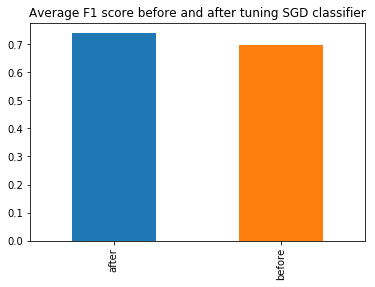

In [102]:
sgd_df.mean().plot('bar').set_title('Average F1 score before and after tuning SGD classifier')
print('The tuning of the stochastic gradient descent classifier improved F1 scores by {:.0%} points.'.format(sgd_df.mean()[0]-sgd_df.mean()[1]))

The tuning of the linear support vector classifier improved F1 scores by 6% points.


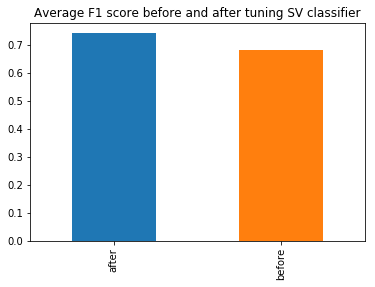

In [103]:
svc_df.mean().plot('bar').set_title('Average F1 score before and after tuning SV classifier')
print('The tuning of the linear support vector classifier improved F1 scores by {:.0%} points.'.format(svc_df.mean()[0]-svc_df.mean()[1]))

The tuning of the naive bayes classifier improved F1 scores by 22% points.


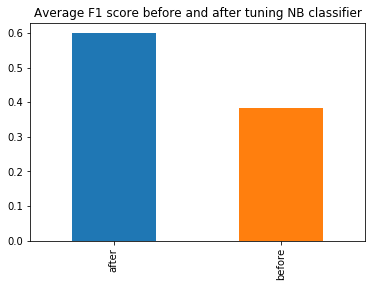

In [104]:
nb_df.mean().plot('bar').set_title('Average F1 score before and after tuning NB classifier')
print('The tuning of the naive bayes classifier improved F1 scores by {:.0%} points.'.format(nb_df.mean()[0]-nb_df.mean()[1]))

The tuning of the random forest classifier improved F1 scores by 5% points.


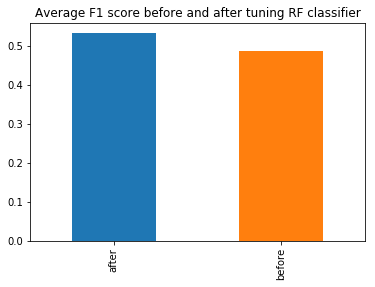

In [105]:
rf_df.mean().plot('bar').set_title('Average F1 score before and after tuning RF classifier')
print('The tuning of the random forest classifier improved F1 scores by {:.0%} points.'.format(rf_df.mean()[0]-rf_df.mean()[1]))